In [1]:
# public libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [2]:
import tensorflow as tf
import numpy as np
from tensorflow import keras

%load_ext tensorboard

2023-08-27 09:24:06.076336: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-27 09:24:06.238911: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-08-27 09:24:06.848839: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-08-27 09:24:06.848932: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

## retrieve data

In [3]:
# we'll read both of these values and the original input and irrelevant tcrs
X_cdr3s = pd.read_csv('../outputs/model_v3/cdr3.conversion.n30.csv', index_col=0)
X_epitopes = pd.read_csv('../outputs/model_v3/epitope.conversion.n15.csv', index_col=0)
hit = pd.read_csv('../outputs/model_v3/full.input.X.csv', index_col=0)
irr = pd.read_csv('../outputs/model_v3/full.control.X.csv', index_col=0)
irr = irr.reset_index().iloc[:, 1:]

In [4]:
# grab a subset
np.random.seed(0)
n_rows = 50000
perc_train = 0.75
# > subset target
idxs = np.random.choice(hit.index, size=n_rows, replace=False)
idxs, idys = idxs[:round(n_rows * perc_train)], idxs[round(n_rows * perc_train):]
print(len(idxs), len(idys))
hit_train, hit_test = hit.loc[idxs], hit.loc[idys]
# > subset control
idxs = np.random.choice(irr.index, size=n_rows, replace=False)
idxs, idys = idxs[:round(n_rows * perc_train)], idxs[round(n_rows * perc_train):]
print(len(idxs), len(idys))
irr_train, irr_test = irr.loc[idxs], irr.loc[idys]

37500 12500
37500 12500


In [5]:
# > subset target
val_idxs = hit.index[~hit.index.isin(hit_train.index.union(hit_test.index))]
print(len(val_idxs))
hit_val = hit.loc[val_idxs]
# > subset control
val_idxs = irr.index[~irr.index.isin(irr_train.index.union(irr_test.index))]
print(len(val_idxs))
irr_val = irr.loc[val_idxs]

77014
38001


## split into testing and validation

In [6]:
# create X for testing
X_test = hit_test.append(irr_test).reset_index().iloc[:, 1:]
X_test_cdr3s = X_cdr3s.loc[X_test['CDR3']].reset_index().iloc[:, 1:]
X_test_epitopes = X_epitopes.loc[X_test['Epitope']].reset_index().iloc[:, 1:]
# combine
X_test_cdr3s.columns = 'cdr3:' + X_test_cdr3s.columns
X_test_epitopes.columns = 'ag:' + X_test_epitopes.columns
X_test = X_test_cdr3s.join(X_test_epitopes)

# grab y for testing
y_test = pd.Series(np.ones(hit_test.shape[0])).append(pd.Series(np.zeros(irr_test.shape[0]))).astype(int)
y_test = y_test.reset_index().iloc[:, 1:][0]

In [7]:
# create X for validation
X_val = hit_val.append(irr_val).reset_index().iloc[:, 1:]
X_val_cdr3s = X_cdr3s.loc[X_val['CDR3']].reset_index().iloc[:, 1:]
X_val_epitopes = X_epitopes.loc[X_val['Epitope']].reset_index().iloc[:, 1:]
# combine
X_val_cdr3s.columns = 'cdr3:' + X_val_cdr3s.columns
X_val_epitopes.columns = 'ag:' + X_val_epitopes.columns
X_val = X_val_cdr3s.join(X_val_epitopes)

# grab y for validation
y_val = pd.Series(np.ones(hit_val.shape[0])).append(pd.Series(np.zeros(irr_val.shape[0]))).astype(int)
y_val = y_val.reset_index().iloc[:, 1:][0]

In [8]:
# read in normalization factors
means = pd.read_csv('../outputs/model_v5/model_v5.means.csv', index_col=0).iloc[:, 0]
stds = pd.read_csv('../outputs/model_v5/model_v5.stds.csv', index_col=0).iloc[:, 0]
# subset for relevant columns
X_test = X_test[means.index]
X_val = X_val[means.index]
# normalize
X_test -= means
X_test /= stds
X_val -= means
X_val /= stds

## compare with other models

In [9]:
!mkdir ../outputs/model_comparison

mkdir: cannot create directory ‘../outputs/model_comparison’: File exists


In [10]:
# select for epitopes that are test-able
for epitope in ['GILGFVFTL','NLVPMVATV','GLCTLVAML']:
    # append the original dataframes together for further testing
    df_test = hit_test.append(irr_test).reset_index().iloc[:, 1:]
    df_val = hit_val.append(irr_val).reset_index().iloc[:, 1:]
    # subset on the relevant peptide
    df_test = df_test.loc[df_test['Epitope'] == epitope]
    df_val = df_val.loc[df_val['Epitope'] == epitope]
    # write the files down
    df_test.to_csv(f'../outputs/model_comparison/test.{epitope}.csv')
    df_val.to_csv(f'../outputs/model_comparison/val.{epitope}.csv')

In [11]:
# get it in nice plotting stage
from sklearn.metrics import roc_curve, auc, accuracy_score
import scanpy as sc
sc.settings.set_figure_params(dpi=100)

In [52]:
def evaluation(epitope):
    # append the original dataframes together for further testing
    df_test = hit_test.append(irr_test).reset_index().iloc[:, 1:]
    df_val = hit_val.append(irr_val).reset_index().iloc[:, 1:]
    # focus on GILGFVFTL for now
    X = X_test.loc[df_test['Epitope'] == epitope]
    y = y_test.loc[df_test['Epitope'] == epitope]

    # retrieve the appropriate columns
    cols_cdr3 = X.columns[X.columns.str.startswith('cdr3')]
    cols_ag = X.columns[X.columns.str.startswith('ag')]

    # load in the model
    model = keras.models.load_model('../outputs/model_v5/model_v5.keras')

    # > our model
    # testing predictions
    y_pred = model.predict([X[cols_cdr3], X[cols_ag]], workers=40, use_multiprocessing=True)[:, 0]
    y_pred = pd.Series(y_pred, index=y.index, name='Pred%')
    y_pred = pd.concat([y_pred, y], axis=1)

    # retrieve auc metrics
    fpr_modelv5, tpr_modelv5, _ = roc_curve(y_pred[0], y_pred['Pred%'])
    print('Model v5')
    print('AUC', auc(fpr_modelv5, tpr_modelv5))
    print('ACC', accuracy_score(y_pred[0], y_pred['Pred%'].apply(round)))
    print()
    
    # > pMTnet
    # testing predictions
    y_pred = pd.read_csv(f'../outputs/model_comparison/test.{epitope}.pMTnet.results/prediction.csv')
    y_pred = 1 - y_pred['Rank'].values
    y_pred = pd.Series(y_pred, index=y.index, name='Pred%')
    y_pred = pd.concat([y_pred, y], axis=1)

    # retrieve auc metrics
    fpr_pmtnet, tpr_pmtnet, _ = roc_curve(y_pred[0], y_pred['Pred%'])
    print('pMTnet')
    print('AUC', auc(fpr_pmtnet, tpr_pmtnet))
    print('ACC', accuracy_score(y_pred[0], y_pred['Pred%'].apply(round)))
    print()
    
    # > ATM-TCR
    # testing predictions
    y_pred = pd.read_table(f'../outputs/model_comparison/pred_original_test.{epitope}.ATMTCR.csv', header=None)
    y_pred = y_pred[4].values
    y_pred = pd.Series(y_pred, index=y.index, name='Pred%')
    y_pred = pd.concat([y_pred, y], axis=1)

    # retrieve auc metrics
    fpr_atmtcr, tpr_atmtcr, _ = roc_curve(y_pred[0], y_pred['Pred%'])
    print('ATM-TCR')
    print('AUC', auc(fpr_atmtcr, tpr_atmtcr))
    print('ACC', accuracy_score(y_pred[0], y_pred['Pred%'].apply(round)))
    print()
    
    # > ImRex
    # testing predictions
    y_pred = pd.read_csv(f'../outputs/model_comparison/test.{epitope}.ImRex.result.csv')
    y_pred = y_pred.groupby('cdr3').mean(numeric_only=True).reindex(df_test.loc[y.index, 'CDR3']).fillna(0)
    y_pred = y_pred['prediction_score'].values
    y_pred = pd.Series(y_pred, index=y.index, name='Pred%')
    y_pred = pd.concat([y_pred, y], axis=1)

    # retrieve auc metrics
    fpr_imrex, tpr_imrex, _ = roc_curve(y_pred[0], y_pred['Pred%'])
    print('ImRex')
    print('AUC', auc(fpr_imrex, tpr_imrex))
    print('ACC', accuracy_score(y_pred[0], y_pred['Pred%'].apply(round)))
    print()

    # > Net-TCR-2.0
    # testing predictions
    y_pred = pd.read_csv(f'../outputs/model_comparison/test.{epitope}.NetTCR2.results.csv')
    y_pred = y_pred['prediction'].values
    y_pred = pd.Series(y_pred, index=y.index, name='Pred%')
    y_pred = pd.concat([y_pred, y], axis=1)

    # retrieve auc metrics
    fpr_nettcr2, tpr_nettcr2, _ = roc_curve(y_pred[0], y_pred['Pred%'])
    print('Net-TCR-2.0')
    print('AUC', auc(fpr_nettcr2, tpr_nettcr2))
    print('ACC', accuracy_score(y_pred[0], y_pred['Pred%'].apply(round)))
    print()

    # > now read in predictions from ERGO-II (LSTM model, used HLA and CDR3b and Peptide)
    # testing predictions
    y_pred = pd.read_csv(f'../outputs/model_comparison/test.{epitope}.ERGOII.results.csv')
    y_pred = y_pred['Score'].values
    y_pred = pd.Series(y_pred, index=y.index, name='Pred%')
    y_pred = pd.concat([y_pred, y], axis=1)

    # retrieve auc metrics
    fpr_ergoii, tpr_ergoii, _ = roc_curve(y_pred[0], y_pred['Pred%'])
    print('ERGO-II McPAS')
    print('AUC', auc(fpr_ergoii, tpr_ergoii))
    print('ACC', accuracy_score(y_pred[0], y_pred['Pred%'].apply(round)))
    print()
    print()

    # > now read in predictions from ERGO-II
    # testing predictions
    y_pred = pd.read_csv(f'../outputs/model_comparison/test.{epitope}.ERGOII.results_vdjdb.csv')
    y_pred = y_pred['Score'].values
    y_pred = pd.Series(y_pred, index=y.index, name='Pred%')
    y_pred = pd.concat([y_pred, y], axis=1)

    # retrieve auc metrics
    fpr_ergoii_vdjdb, tpr_ergoii_vdjdb, _ = roc_curve(y_pred[0], y_pred['Pred%'])
    print('ERGO-II VDJdb')
    print('AUC', auc(fpr_ergoii_vdjdb, tpr_ergoii_vdjdb))
    print('ACC', accuracy_score(y_pred[0], y_pred['Pred%'].apply(round)))
    print()

    # check the AUC
    fig, ax = plt.subplots(figsize=[6, 6])
    ax.plot(fpr_modelv5, tpr_modelv5, lw=3, label='TARPON (this study)')
    ax.plot(fpr_nettcr2, tpr_nettcr2, lw=3, label='NetTCR - 2.0')
    ax.plot(fpr_ergoii, tpr_ergoii, lw=3, label='ERGO-II McPAS')
    ax.plot(fpr_ergoii_vdjdb, tpr_ergoii_vdjdb, lw=3, label='ERGO-II VDJdb')
    plt.plot(fpr_pmtnet, tpr_pmtnet, lw=3, label='pMTnet')
    plt.plot(fpr_atmtcr, tpr_atmtcr, lw=3, label='ATM-TCR')
    plt.plot(fpr_imrex, tpr_imrex, lw=3, label='ImRex')
    ax.plot([0, 1], [0, 1], color='r', linestyle='--')
    ax.grid(False)
    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR')
    ax.set_title(f'{epitope} on Validation Data')
    ax.legend(frameon=False, bbox_to_anchor=(1.01, 1.01),
              loc='upper left', bbox_transform=ax.transAxes)
    ax.set_xlim(-0.01, 1.01)
    ax.set_ylim(-0.01, 1.01)

78/78 [==============================] - 0s 2ms/step
Model v5
AUC 0.9562033867567384
ACC 0.9273314493338716

pMTnet
AUC 0.5427134991552444
ACC 0.5159467097295115

ATM-TCR
AUC 0.4795508460224477
ACC 0.5530884134033105

ImRex
AUC 0.7207485855176745
ACC 0.6350423899878885

Net-TCR-2.0
AUC 0.6470054845777089
ACC 0.7420266451352443

ERGO-II McPAS
AUC 0.5927237669034472
ACC 0.6576503835284618


ERGO-II VDJdb
AUC 0.6174190348049995
ACC 0.6431166733952361



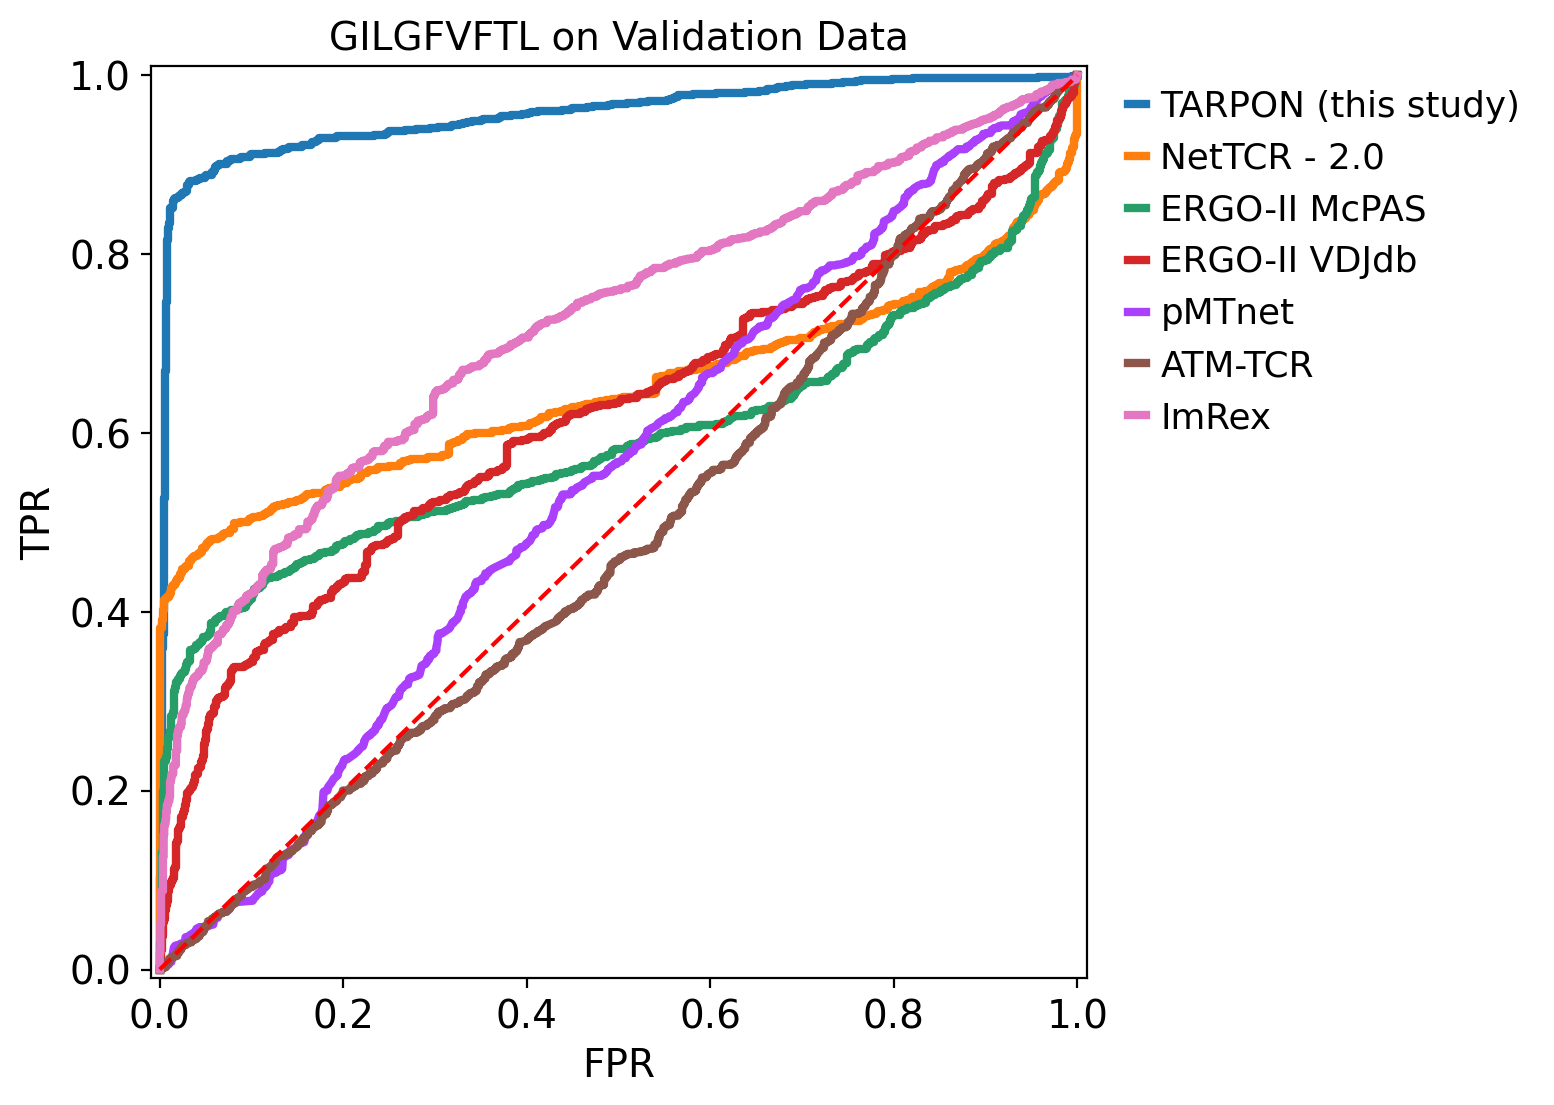

In [53]:
evaluation('GILGFVFTL')

40/40 [==============================] - 0s 2ms/step
Model v5
AUC 0.9702054160755043
ACC 0.9290836653386454

pMTnet
AUC 0.5393726996072625
ACC 0.5378486055776892

ATM-TCR
AUC 0.5205043386178109
ACC 0.4709163346613546

ImRex
AUC 0.46782020438796706
ACC 0.46693227091633466

Net-TCR-2.0
AUC 0.2999635021487468
ACC 0.5545816733067729

ERGO-II McPAS
AUC 0.8400777250015423
ACC 0.7888446215139442


ERGO-II VDJdb
AUC 0.5521765056648777
ACC 0.502788844621514



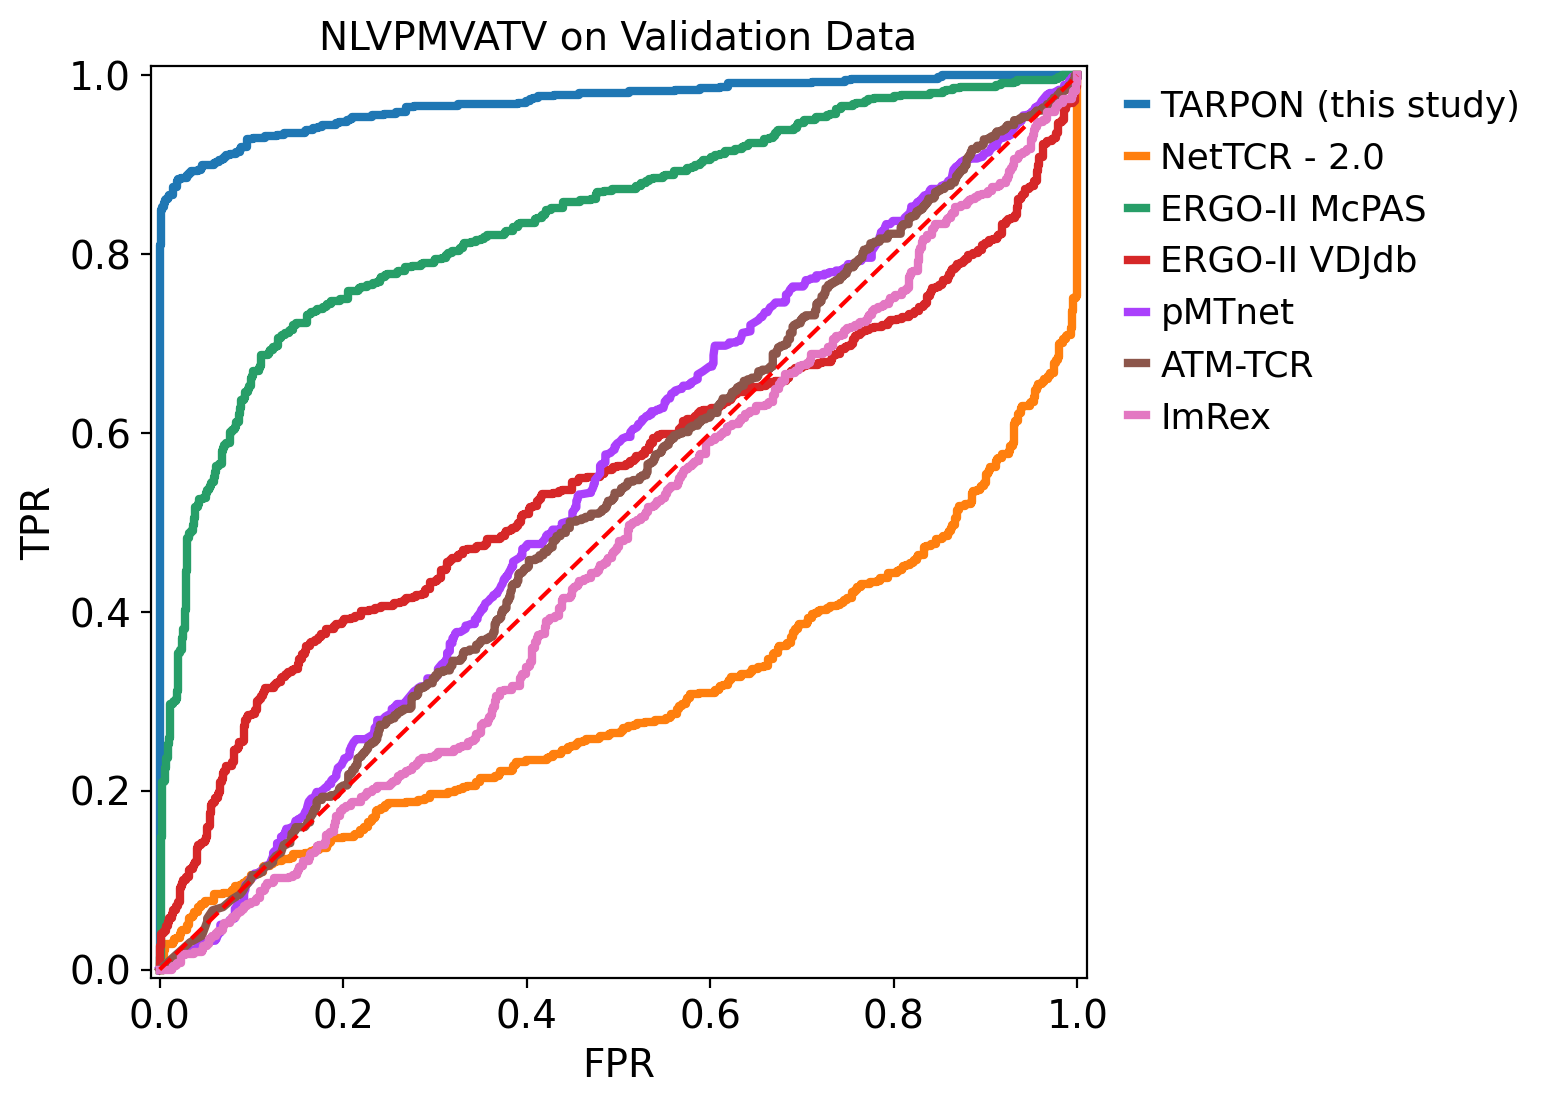

In [54]:
evaluation('NLVPMVATV')

81/81 [==============================] - 0s 2ms/step
Model v5
AUC 0.9438884070398552
ACC 0.8864426419466975

pMTnet
AUC 0.39524892075371565
ACC 0.4279644650444187

ATM-TCR
AUC 0.5142012717538458
ACC 0.45886442641946695

ImRex
AUC 0.5814542244783131
ACC 0.5195056006179992

Net-TCR-2.0
AUC 0.6392239991940972
ACC 0.5851680185399768

ERGO-II McPAS
AUC 0.6090548578982153
ACC 0.6322904596369254


ERGO-II VDJdb
AUC 0.6318123966515724
ACC 0.5936655079181151



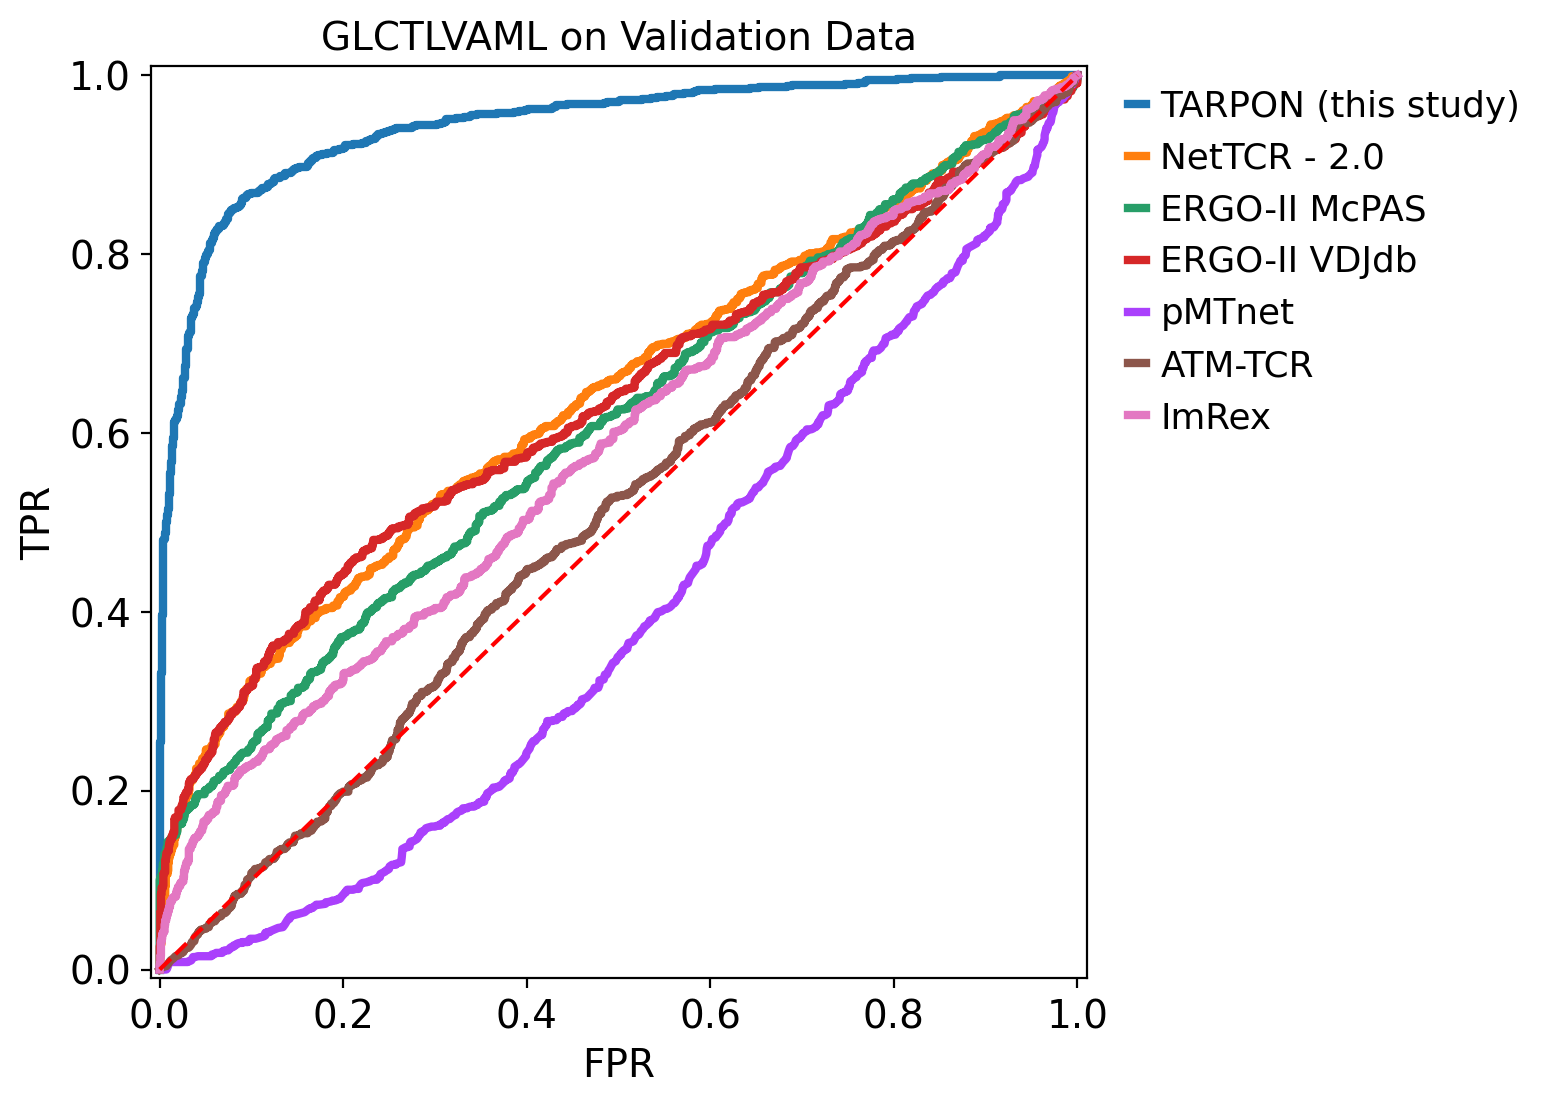

In [55]:
evaluation('GLCTLVAML')

In [68]:
import time

# append the original dataframes together for further testing
df_test = hit_test.append(irr_test).reset_index().iloc[:, 1:]

# retrieve the appropriate columns
cols_cdr3 = X.columns[X.columns.str.startswith('cdr3')]
cols_ag = X.columns[X.columns.str.startswith('ag')]

# load in the model
model = keras.models.load_model('../outputs/model_v5/model_v5.keras')

# set seed
np.random.seed(0)

# check how many rows we need to run for speed
df_time = pd.DataFrame(columns=['k_rows','time_secs'])
for k_rows in range(1, 26, 2):
    # retrieve rows
    k_rows *= 1000
    idxs = np.random.choice(X_test.index, size=k_rows, replace=False)
    
    # track start time
    start_time = time.time()
    # testing predictions
    y_pred = model.predict([X_test.loc[idxs, cols_cdr3], X_test.loc[idxs, cols_ag]],
                           workers=40, use_multiprocessing=True)[:, 0]
    # track delta
    stop_time = time.time()
    df_time.loc[df_time.shape[0]] = k_rows, stop_time - start_time

782/782 [==============================] - 2s 2ms/step


[Text(0.5, 0, 'N-Rows (Thousands)'), Text(0, 0.5, 'Time (Seconds)')]

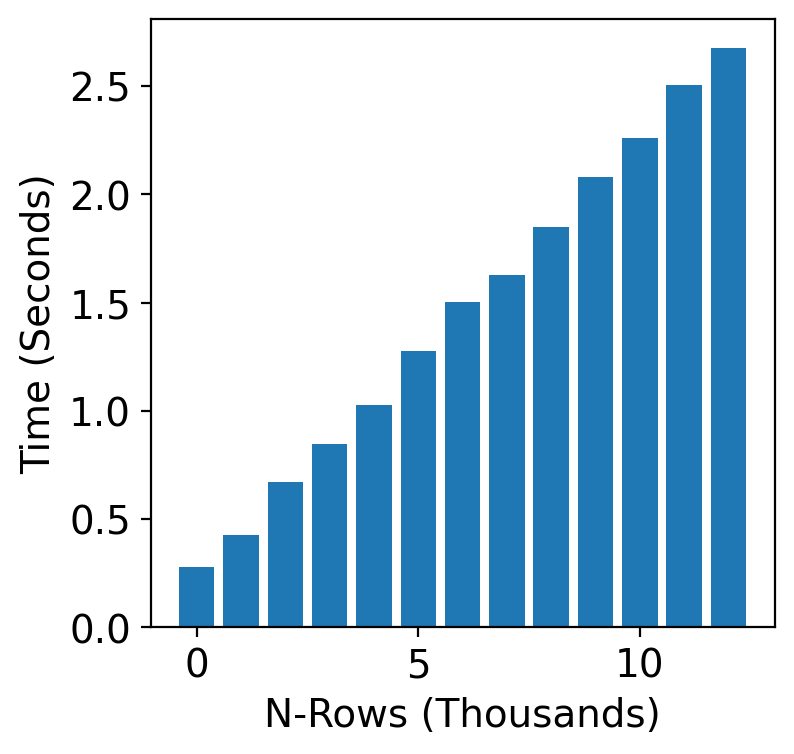

In [73]:
# plot the time it takes to process
fig, ax = plt.subplots()
ax.grid(False)
ax.bar(df_time.index, df_time['time_secs'])
ymin, ymax = ax.get_ylim()
ax.set_ylim(0, ymax)
ax.set(xlabel='N-Rows (Thousands)', ylabel='Time (Seconds)')